In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 1. Load data

In [2]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

from transformer.data_preprocessing import load_and_clean_data, prepare_data_for_modeling
from transformer.tab_transformer import ESGPreprocessor

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'Data', 'energy_cleaned.csv')

# Load the data
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Indep Directors,Raw Materials Used,Percentage Gender Pay Gap Employees Ex Management,Percentage Raw Material from Sustainable Sources,"Revenue, Adj","Net Income, Adj",Margin %,"EPS, Adj",Market Cap ($M),Market Cap Category
0,ACS Actividades de Construccion y Servicios SA,ACS,2014,NaN,NaN,NaN,NaN,50.729,37.511,33.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.850,0.660,2.380,3.660,55.296,42.616,41.717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.170,1.130,2.370,4.050,55.497,48.354,36.578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.760,1.130,4.300,4.110,57.248,50.317,44.891,...,NaN,"5,140.650",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.630,1.110,4.200,3.640,62.609,52.280,59.039,...,NaN,"8,653.300",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap


In [4]:
df['BESG ESG Score'].isna().sum()

363

In [5]:
# Remove rows with missing BESG ESG Score
df = df.dropna(subset=['BESG ESG Score'])
df['BESG ESG Score'].isna().sum()

0

In [6]:
# Drop columns with more than 70% missing values
df = df.dropna(thresh=0.7*len(df), axis=1)
df.shape

(861, 67)

In [7]:
# Drop Market Cap column
df = df.drop(columns=['Market Cap ($M)'])

# Drop rows with '#N/A Requesting Data...'
df = df[~df['BESG ESG Score'].str.contains('#N/A Requesting Data...')]
df.shape

(850, 66)

In [8]:
print("Total number of rows: ", df.shape[0])

# Count the number of missing values in each column
missing = df.isnull().sum()

# Display columns with missing values
missing = missing[missing > 0]

# Arrange the columns by the number of missing values
missing = missing.sort_values(ascending=False)
missing

Total number of rows:  850


Total Energy Consumption                              258
Nitrogen Oxide Emissions                              257
Fatalities - Total                                    245
Total Recordable Incident Rate - Employees            235
Fair Remuneration Policy                              226
Total Water Withdrawal                                225
Nomination Committee Meeting Attendance Percentage    220
Verification Type                                     215
Environmental Supply Chain Management                 212
Energy Efficiency Policy                              212
Fatalities - Employees                                205
Biodiversity Policy                                   195
Compensation Committee Meeting Attendance %           190
Pct Women in Workforce                                183
Employee CSR Training                                 180
Water Policy                                          179
Emissions Reduction Initiatives                       179
Climate Change

In [9]:
# Check basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of companies: {df['Company'].nunique()}")
print(f"Year range: {df['Year'].min()} to {df['Year'].max()}")

Dataset shape: (850, 66)
Number of companies: 118
Year range: 2015 to 2023


### 2. Exploratory Data Analysis

#### Missing Value Analysis

In [10]:
# Calculate missing values percentage
missing_values = df.isnull().sum() / len(df) * 100
missing_df = pd.DataFrame({'column': missing_values.index, 'percent_missing': missing_values.values})
missing_df = missing_df.sort_values('percent_missing', ascending=False)

# Display columns with missing values
missing_df = missing_df[missing_df['percent_missing'] > 0]
missing_df

,column,percent_missing
45,Total Energy Consumption,30.352941
11,Nitrogen Oxide Emissions,30.235294
18,Fatalities - Total,28.823529
19,Total Recordable Incident Rate - Employees,27.647059
62,Fair Remuneration Policy,26.588235
46,Total Water Withdrawal,26.470588
43,Nomination Committee Meeting Attendance Percen...,25.882353
63,Verification Type,25.294118
59,Environmental Supply Chain Management,24.941176
57,Energy Efficiency Policy,24.941176


In [11]:
numeric_cols = [
    'BESG ESG Score', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score',
    'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score',
    'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions',
    'VOC Emissions', 'Particulate Emissions', 'Sulphur Dioxide / Sulphur Oxide Emissions',
    'GHG Scope 1', 'GHG Scope 2 Location-Based', 'GHG Scope 3', 'Carbon per Unit of Production',
    'Fuel Used - Natural Gas', 'Energy Per Unit of Production', 'Community Spending',
    'Pct Women in Middle and or Other Management', 'Pct Women in Workforce',
    'Fatalities - Employees', 'Fatalities - Contractors', 'Fatalities - Total',
    'Lost Time Incident Rate - Employees', 'Lost Time Incident Rate - Contractors',
    'Lost Time Incident Rate - Workforce', 'Total Recordable Incident Rate - Employees',
    'Total Recordable Incident Rate - Contractors', 'Total Recordable Incident Rate - Workforce',
    'Number of Employees - CSR', 'Number of Contractors', 'Employee Turnover Pct',
    'Years Auditor Employed', 'Size of Audit Committee',
    'Number of Independent Directors on Audit Committee', 'Audit Committee Meetings',
    'Audit Committee Meeting Attendance Percentage', 'Board Size',
    'Number of Executives / Company Managers', 'Number of Non Executive Directors on Board',
    'Number of Board Meetings for the Year', 'Board Meeting Attendance Pct',
    'Size of Compensation Committee', 'Num of Independent Directors on Compensation Cmte',
    'Number of Compensation Committee Meetings', 'Compensation Committee Meeting Attendance %',
    'Number of Female Executives', 'Number of Women on Board',
    'Age of the Youngest Director', 'Age of the Oldest Director',
    'Number of Independent Directors', 'Size of Nomination Committee',
    'Num of Independent Directors on Nomination Cmte', 'Number of Nomination Committee Meetings',
    'Nomination Committee Meeting Attendance Percentage', 'Board Duration (Years)',
    'Carbon Monoxide Emissions', 'CO2 Scope 1', 'Total Energy Consumption',
    'Electricity Used', 'Total Waste', 'Waste Recycled', 'Waste Sent to Landfills',
    'Total Water Withdrawal', 'Total Water Discharged', 'Water Consumption',
    'Pct Women in Senior Management', 'Pct Minorities in Workforce',
    'Pct Employees Unionized', 'Employee Training Cost',
    'Total Hours Spent by Firm - Employee Training', 'Fuel Used - Coal/Lignite',
    'Fuel Used - Crude Oil/Diesel', 'Hazardous Waste',
    'Pct Minorities in Management', 'Pct Disabled in Workforce',
    'CO2 Scope 2 Location-Based', 'Water per Unit of Production', 'Pct Recycled Materials',
    'Number of Suppliers Audited', 'Percentage Suppliers Audited',
    'Number of Supplier Audits Conducted', 'Number Supplier Facilities Audited',
    'Percentage of Suppliers in Non-Compliance', 'Number of Customer Complaints',
    'Raw Materials Used', 'Revenue, Adj', 'Net Income, Adj'
]

for col in df.columns:
    if col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.dtypes

Company                             object
Ticker                              object
Year                                 int64
BESG ESG Score                     float64
BESG Environmental Pillar Score    float64
                                    ...   
Biodiversity Policy                 object
Fair Remuneration Policy            object
Verification Type                   object
Employee CSR Training               object
Market Cap Category                 object
Length: 66, dtype: object

In [12]:
binary_cols = [
    'Risks of Climate Change Discussed', 'Policy Against Child Labor',
    'Gender Pay Gap Breakout', 'Human Rights Policy', 'Equal Opportunity Policy',
    'Business Ethics Policy', 'Anti-Bribery Ethics Policy', 'Health and Safety Policy',
    'Training Policy', 'Social Supply Chain Management', 'Emissions Reduction Initiatives',
    'Climate Change Policy', 'Climate Change Opportunities Discussed',
    'Energy Efficiency Policy', 'Waste Reduction Policy',
    'Environmental Supply Chain Management', 'Water Policy', 'Biodiversity Policy',
    'Quality Assurance and Recall Policy', 'Consumer Data Protection Policy',
    'Fair Remuneration Policy', 'Employee CSR Training', 'Renewable Energy Use',
    'Company Conducts Board Evaluations', 'Company Has Executive Share Ownership Guidelines',
    'Director Share Ownership Guidelines', 'Transition Plan Claim',
    'Adopts TNFD Recommendations', 'Zero Deforestation Policy',
    'Board Level Oversight of Biodiversity', 'Executive Level Oversight of Biodiversity',
    'Company Discloses Employee Engagement Score', 'Verification Type'
]

# Impute missing values for numeric columns
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

# Impute missing values for binary columns
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).astype('bool')
        df[col] = df[col].fillna(df[col].mode()[0])

# Impute missing values for categorical columns
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Company', 'Ticker']:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype('category')

# Check if there are any missing values
df.isnull().sum()

df.to_csv('energy_imputed.csv', index=False)

In [13]:
# Check column data types
df.dtypes

Company                              object
Ticker                               object
Year                                  int64
BESG ESG Score                      float64
BESG Environmental Pillar Score     float64
                                     ...   
Biodiversity Policy                    bool
Fair Remuneration Policy               bool
Verification Type                      bool
Employee CSR Training                  bool
Market Cap Category                category
Length: 66, dtype: object

In [14]:
# One-hot encode categorical columns without Company and Ticker
df = pd.get_dummies(df, columns=df.select_dtypes(include='category').columns)

df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Water Policy,Biodiversity Policy,Fair Remuneration Policy,Verification Type,Employee CSR Training,Market Cap Category_Large Cap,Market Cap Category_Mega Cap,Market Cap Category_Mid Cap,Market Cap Category_Small Cap,Market Cap Category_Unknown
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.66,55.296,42.616,41.717,...,True,True,False,True,False,False,False,True,False,False
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.05,55.497,48.354,36.578,...,True,True,False,True,False,False,False,True,False,False
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.11,57.248,50.317,44.891,...,True,True,False,True,False,False,False,True,False,False
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.64,62.609,52.280,59.039,...,True,True,False,True,False,False,False,True,False,False
5,ACS Actividades de Construccion y Servicios SA,ACS,2019,2.79,1.31,4.21,3.87,64.390,57.626,59.039,...,True,True,False,True,False,False,False,True,False,False


#### ESG Score Distribution


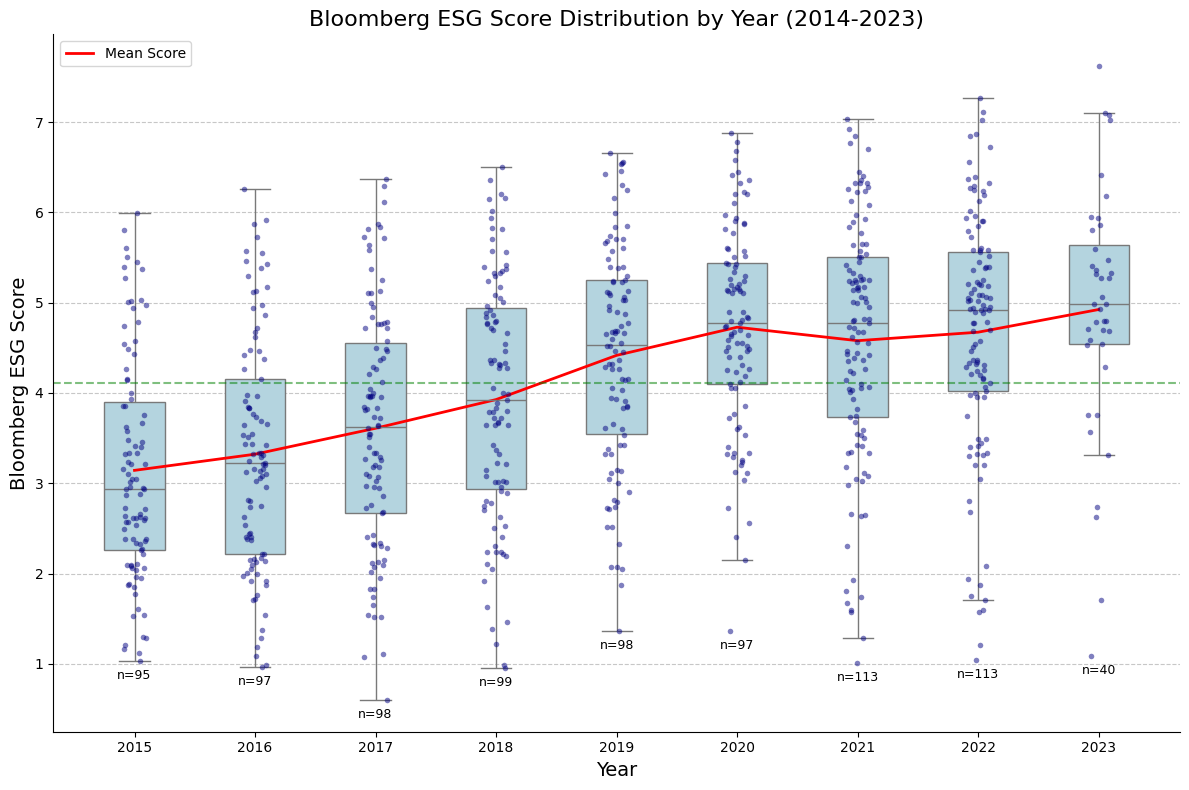

In [15]:
# Convert 'BESG ESG Score' to numeric, forcing errors to NaN
df['BESG ESG Score'] = pd.to_numeric(df['BESG ESG Score'], errors='coerce')

# Filter only rows with BESG ESG Score data
df_filtered = df.dropna(subset=['BESG ESG Score'])

# Drop rows with Years before 2014
df_filtered = df_filtered[df_filtered['Year'] >= 2015]

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create the box plot without outliers
ax = sns.boxplot(x='Year', y='BESG ESG Score', data=df_filtered,
                 color='lightblue', width=0.5, showfliers=False)

# Add individual data points with jitter
sns.stripplot(x='Year', y='BESG ESG Score', data=df_filtered,
              size=4, color='navy', alpha=0.5, jitter=True)

# Add a trend line showing the mean score per year
means = df_filtered.groupby('Year')['BESG ESG Score'].mean()
plt.plot(range(len(means)), means.values, 'r-', linewidth=2, label='Mean Score')

# Enhance the plot with labels and title
plt.title('Bloomberg ESG Score Distribution by Year (2014-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Bloomberg ESG Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Annotate with some key statistics
for i, year in enumerate(sorted(df_filtered['Year'].unique())):
    year_data = df_filtered[df_filtered['Year'] == year]['BESG ESG Score']
    if not year_data.empty:
        plt.annotate(f'n={len(year_data)}',
                    xy=(i, year_data.min() - 0.2),
                    ha='center', fontsize=9)

# Add a horizontal line at the overall mean
plt.axhline(y=df_filtered['BESG ESG Score'].mean(), color='green',
           linestyle='--', alpha=0.5, label='Overall Mean')

# Improve aesthetics
sns.despine(left=False, bottom=False)
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
# Filter out Large Cap and Mega Cap companies and create a new DataFrame
# Find True for Market Cap Category_Large Cap and Market Cap Category_Mega Cap
df_large_cap = df_filtered[df_filtered['Market Cap Category_Large Cap'] | df_filtered['Market Cap Category_Mega Cap']]
df_large_cap.shape

(220, 70)

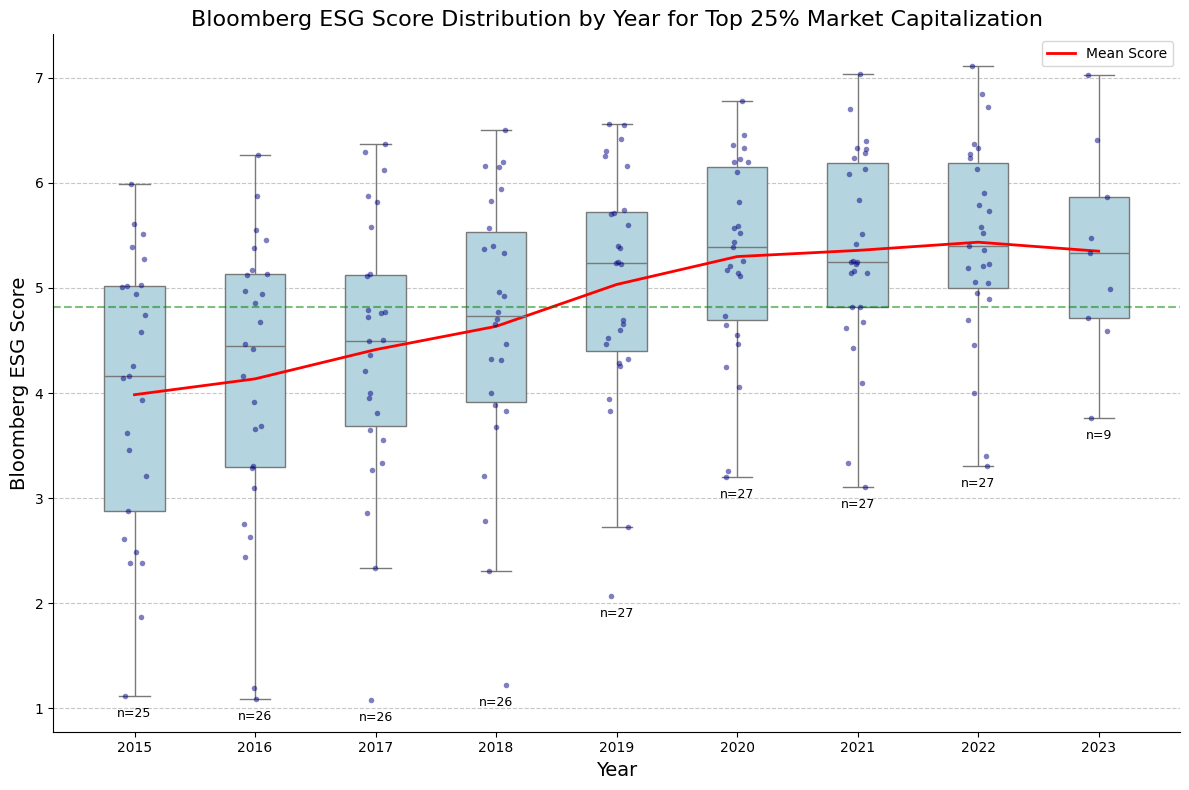

In [17]:
# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create the box plot without outliers
ax = sns.boxplot(x='Year', y='BESG ESG Score', data=df_large_cap,
                 color='lightblue', width=0.5, showfliers=False)

# Add individual data points with jitter
sns.stripplot(x='Year', y='BESG ESG Score', data=df_large_cap,
              size=4, color='navy', alpha=0.5, jitter=True)

# Add a trend line showing the mean score per year
means = df_large_cap.groupby('Year')['BESG ESG Score'].mean()
plt.plot(range(len(means)), means.values, 'r-', linewidth=2, label='Mean Score')

# Enhance the plot with labels and title
plt.title('Bloomberg ESG Score Distribution by Year for Top 25% Market Capitalization', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Bloomberg ESG Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Annotate with some key statistics
for i, year in enumerate(sorted(df_large_cap['Year'].unique())):
    year_data = df_large_cap[df_large_cap['Year'] == year]['BESG ESG Score']
    if not year_data.empty:
        plt.annotate(f'n={len(year_data)}',
                    xy=(i, year_data.min() - 0.2),
                    ha='center', fontsize=9)

# Add a horizontal line at the overall mean
plt.axhline(y=df_large_cap['BESG ESG Score'].mean(), color='green',
           linestyle='--', alpha=0.5, label='Overall Mean')

# Improve aesthetics
sns.despine(left=False, bottom=False)
plt.tight_layout()

# Show the plot
plt.show()

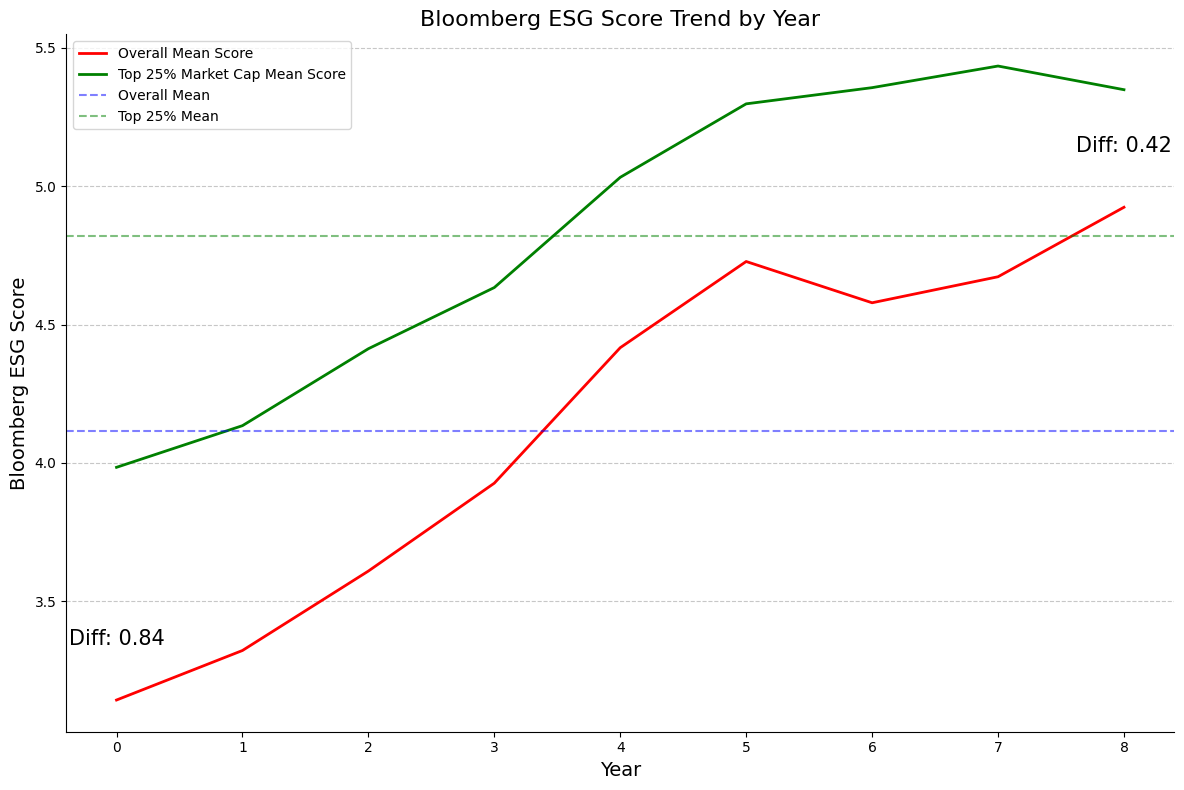

In [18]:
# Show difference in ESG scores between Large Cap and Mega Cap companies and the rest
# Plot the 2 trend lines

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

means = df_filtered.groupby('Year')['BESG ESG Score'].mean()
plt.plot(range(len(means)), means.values, 'r-', linewidth=2, label='Overall Mean Score')

means_2 = df_large_cap.groupby('Year')['BESG ESG Score'].mean()
plt.plot(range(len(means_2)), means_2.values, 'g-', linewidth=2, label='Top 25% Market Cap Mean Score')

# Enhance the plot with labels and title
plt.title('Bloomberg ESG Score Trend by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Bloomberg ESG Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at the overall mean
plt.axhline(y=df_filtered['BESG ESG Score'].mean(), color='blue',
           linestyle='--', alpha=0.5, label='Overall Mean')

# Add a horizontal line at the top 25% mean
plt.axhline(y=df_large_cap['BESG ESG Score'].mean(), color='green',
           linestyle='--', alpha=0.5, label='Top 25% Mean')

# Annotate difference in mean at starting year and ending year
plt.annotate(f'Diff: {means_2[2015] - means[2015]:.2f}',
             xy=(0, means[2015] + 0.2), ha='center', fontsize=15)
plt.annotate(f'Diff: {means_2[2023] - means[2023]:.2f}',
                xy=(8, means[2023] + 0.2), ha='center', fontsize=15)


# Improve aesthetics
sns.despine(left=False, bottom=False)
plt.legend()
plt.tight_layout()

plt.show()

#### Correlation Analysis

{'BESG ESG Score': Number of Women on Board                      0.494079
Number of Independent Directors               0.431593
Climate Change Policy                         0.414074
Year                                          0.408620
Biodiversity Policy                           0.392730
Water Policy                                  0.376537
Verification Type                             0.366105
Number of Non Executive Directors on Board    0.349577
Human Rights Policy                           0.329266
Risks of Climate Change Discussed             0.310427
Name: BESG ESG Score, dtype: float64}


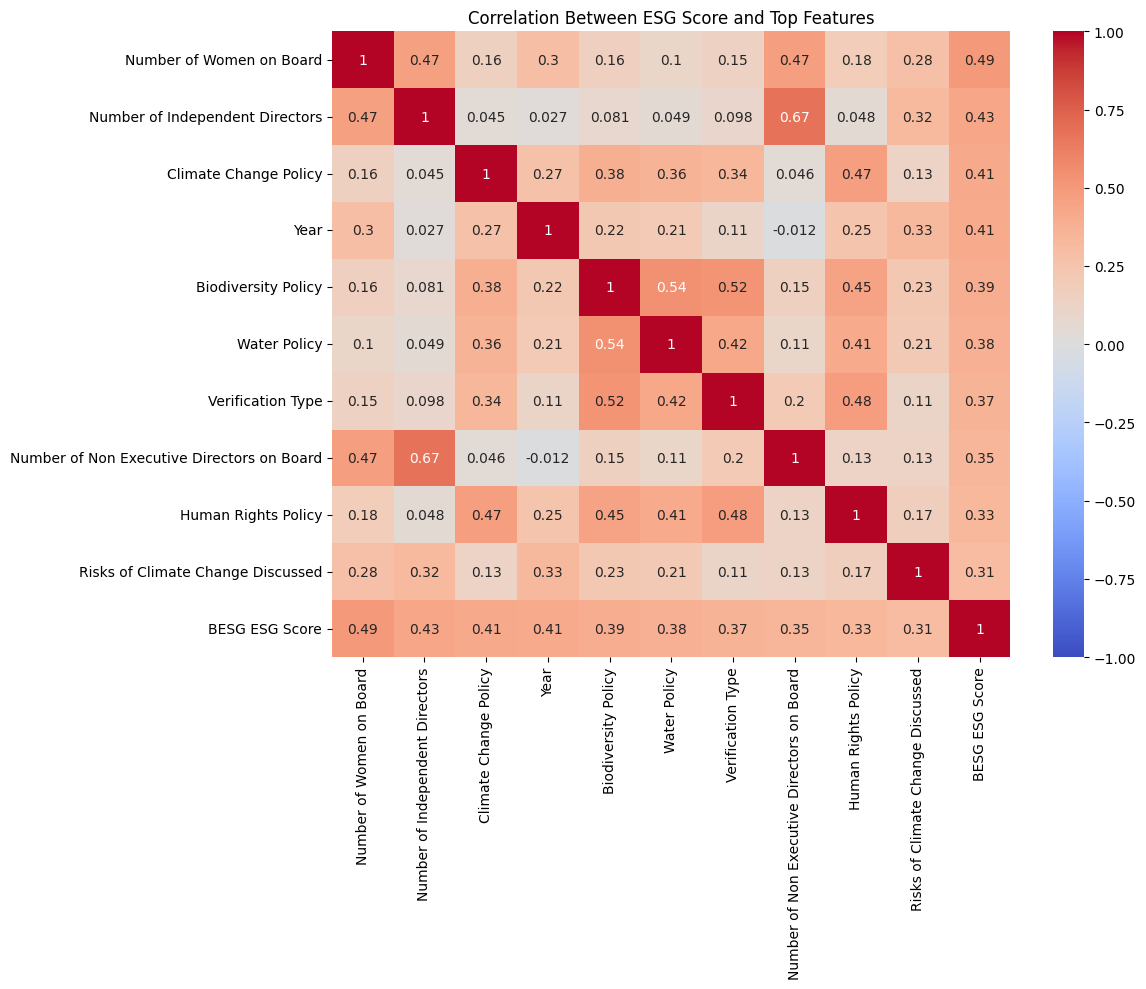

In [19]:
# Drop columns with ESG Pillar Scores
cols_to_drop = ['Company', 'Ticker', 'BESG Environmental Pillar Score',
            'BESG Social Pillar Score', 'BESG Governance Pillar Score',
            'ESG Disclosure Score', 'Environmental Disclosure Score',
            'Social Disclosure Score', 'Governance Disclosure Score']

# Calculate correlation matrix
correlation_matrix = df.drop(columns=cols_to_drop).corr()

# Plot correlation heatmap for ESG scores
esg_cols = ['BESG ESG Score']

# Find top correlated features with ESG scores
esg_correlations = correlation_matrix[esg_cols].drop(esg_cols)
top_correlations = {}

for col in esg_cols:
    # Get absolute correlations and sort
    abs_corr = esg_correlations[col].abs().sort_values(ascending=False)
    # Store top 10 correlated features
    top_correlations[col] = abs_corr.head(10)

print(top_correlations)

# Plot heatmap of top correlations with overall ESG score
plt.figure(figsize=(12, 10))
top_features = top_correlations['BESG ESG Score'].index.tolist()
sns.heatmap(correlation_matrix.loc[top_features + ['BESG ESG Score'],
                                  top_features + ['BESG ESG Score']],
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between ESG Score and Top Features')
plt.tight_layout()

### 3. Regression Analysis

In [20]:
# Prepare data for modeling
# df = load_and_clean_data(file_path)

# Drop rows with missing ESG scores
df, cat_features, num_features = prepare_data_for_modeling(df)

print(f"Number of categorical features: {len(cat_features)}")
print(f"Number of numerical features: {len(num_features)}")

# Show sample of features
print("\nSample categorical features:", cat_features[:5])
print("Sample numerical features:", num_features[:5])

# Split the data into training, validation, and test sets
X = df[cat_features + num_features]

# Verify columns to drop are in the DataFrame
print(f"Columns before dropping: {X.columns.tolist()}")

# Drop the specified columns
cols_to_drop = ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Company', 'Ticker']
X = X.drop(columns=cols_to_drop)

# Verify columns after dropping
print(f"Columns after dropping: {X.columns.tolist()}")

# Update cat_features and num_features to exclude dropped columns
cat_features = [col for col in cat_features if col not in cols_to_drop]
num_features = [col for col in num_features if col not in cols_to_drop]

y = df[['BESG ESG Score', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score']]

# First split: train+val vs test (80% vs 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: train vs val (80% vs 20% of train_val, which is 64% vs 16% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Identified 3 categorical features
Identified 41 numerical features
Number of categorical features: 3
Number of numerical features: 41

Sample categorical features: ['Company', 'Ticker', 'Year']
Sample numerical features: ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score']
Columns before dropping: ['Company', 'Ticker', 'Year', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions', 'GHG Scope 1', 'GHG Scope 2 Location-Based', 'Pct Women in Workforce', 'Fatalities - Employees', 'Fatalities - Total', 'Total Recordable Incident Rate - Employees', 'Number of Employees - CSR', 'Years Auditor Employed', 'Size of Audit Committee', 'Number of Independent Directors on Audit Committee', 'Audit Committee Meetings', 'A

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [33]:
# Prove that BESG ESG Score is calculated from the three pillar scores and the disclosure scores
# Define the features and target
features = ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score']
target = 'BESG ESG Score'

# Create a simple linear regression model
from sklearn.linear_model import LinearRegression

# Create a simple linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(y_train[features], y_train[target])

pred = model.predict(y_val[features])

# Calculate the mean squared error
mse = mean_squared_error(y_val[target], pred)

# Calculate the mean absolute error
mae = mean_absolute_error(y_val[target], pred)

# Calculate the R-squared value
r2 = r2_score(y_val[target], pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 0.0109
Mean Absolute Error: 0.0684
R-squared: 0.9936


In [38]:
def evaluate_multi_target_model(y_true, y_pred, target_columns):
    """
    Evaluate model performance for multiple target variables

    Parameters:
    -----------
    y_true : DataFrame or array
        True target values
    y_pred : DataFrame or array
        Predicted target values
    target_columns : list
        Names of target variables

    Returns:
    --------
    DataFrame with performance metrics for each target variable
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Initialize results storage
    metrics_data = []

    # Calculate metrics for each target variable
    for i, col in enumerate(target_columns):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        metrics_data.append({
            'Target': col,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R-squared': r2
        })

    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics_data)

    return metrics_df

# Preprocessing pipeline setup
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Assuming num_features and cat_features are defined earlier
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Target variables
target_columns = [
    'BESG ESG Score',
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
    'ESG Disclosure Score',
    'Environmental Disclosure Score',
    'Social Disclosure Score',
    'Governance Disclosure Score'
]

# Create and train a Linear Regression model for multi-output regression
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit on training data
lr_model.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test)

# Evaluate performance for each target variable
metrics_df = evaluate_multi_target_model(y_test, lr_predictions, target_columns)

# Print the metrics DataFrame
print("Linear Regression Model Metrics")
print(metrics_df)

# Optional: Save to CSV if needed
metrics_df.to_csv('lr_model_metrics.csv', index=False)

# Create and train the Random Forest model for multi-output regression
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
])

# Fit on training data
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate performance for each target variable
metrics_df = evaluate_multi_target_model(y_test, rf_predictions, target_columns)

# Print the metrics DataFrame
print("Random Forest Model Metrics")
print(metrics_df)

# Optional: Save to CSV if needed
metrics_df.to_csv('rf_model_metrics.csv', index=False)

Linear Regression Model Metrics
                            Target         MSE       RMSE        MAE  \
0                   BESG ESG Score    0.981157   0.990534   0.797241   
1  BESG Environmental Pillar Score    2.323888   1.524430   1.218512   
2         BESG Social Pillar Score    1.944569   1.394478   1.130161   
3     BESG Governance Pillar Score    0.684972   0.827630   0.628790   
4             ESG Disclosure Score  110.343579  10.504455   7.849978   
5   Environmental Disclosure Score  310.053561  17.608338  13.729273   
6          Social Disclosure Score  168.293403  12.972795  10.589781   
7      Governance Disclosure Score  109.605449  10.469262   6.835237   

   R-squared  
0   0.568446  
1   0.462293  
2   0.401115  
3   0.618808  
4   0.494069  
5   0.493686  
6   0.343170  
7   0.275068  
Random Forest Model Metrics
                            Target         MSE       RMSE       MAE  R-squared
0                   BESG ESG Score    0.728802   0.853699  0.657364   0.67944

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/792731519.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')


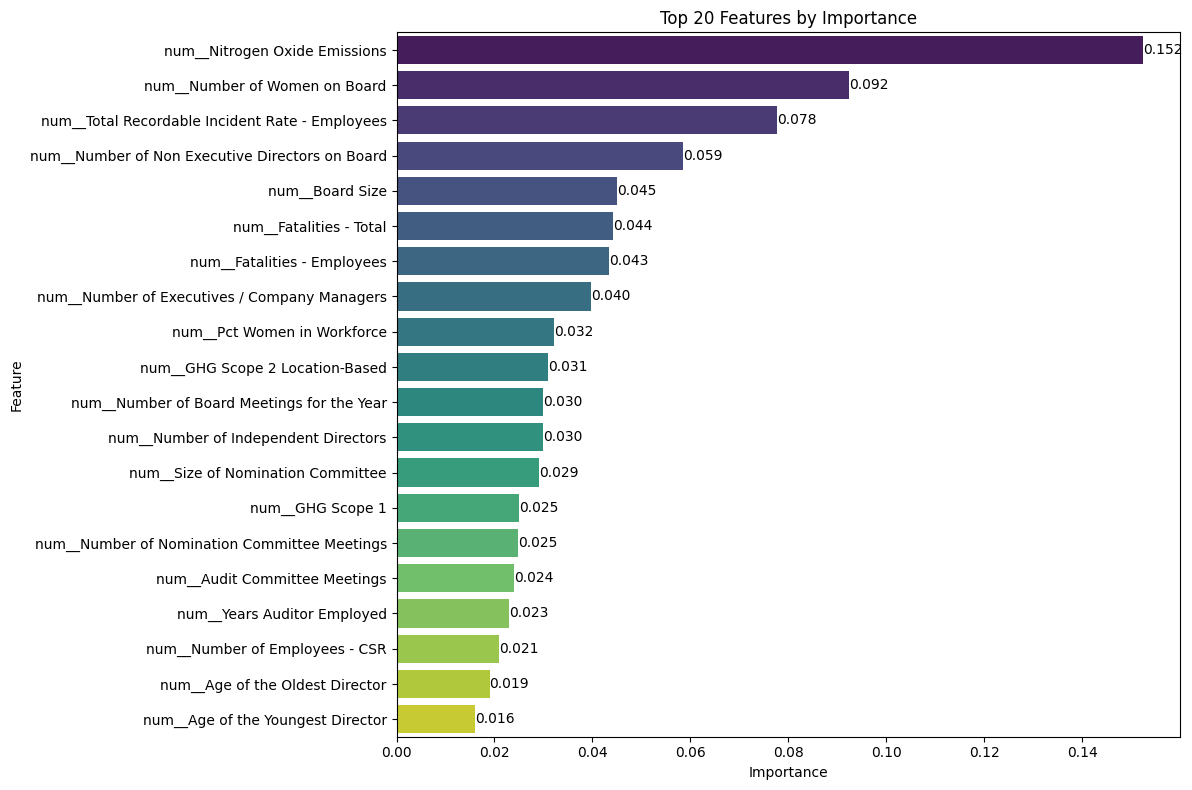

In [28]:
# Extract the trained RandomForestRegressor from the pipeline
rf_regressor = rf_model.named_steps['regressor']

# Get feature importances
importances = rf_regressor.feature_importances_

# Get feature names from the preprocessor
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot top 20 features by importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')
plt.title('Top 20 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
# Label each bar
for i in range(20):
    plt.text(x=feature_importances['Importance'].iloc[i], y=i,
             s=f"{feature_importances['Importance'].iloc[i]:.3f}",
             va='center')
plt.tight_layout()
plt.show()

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


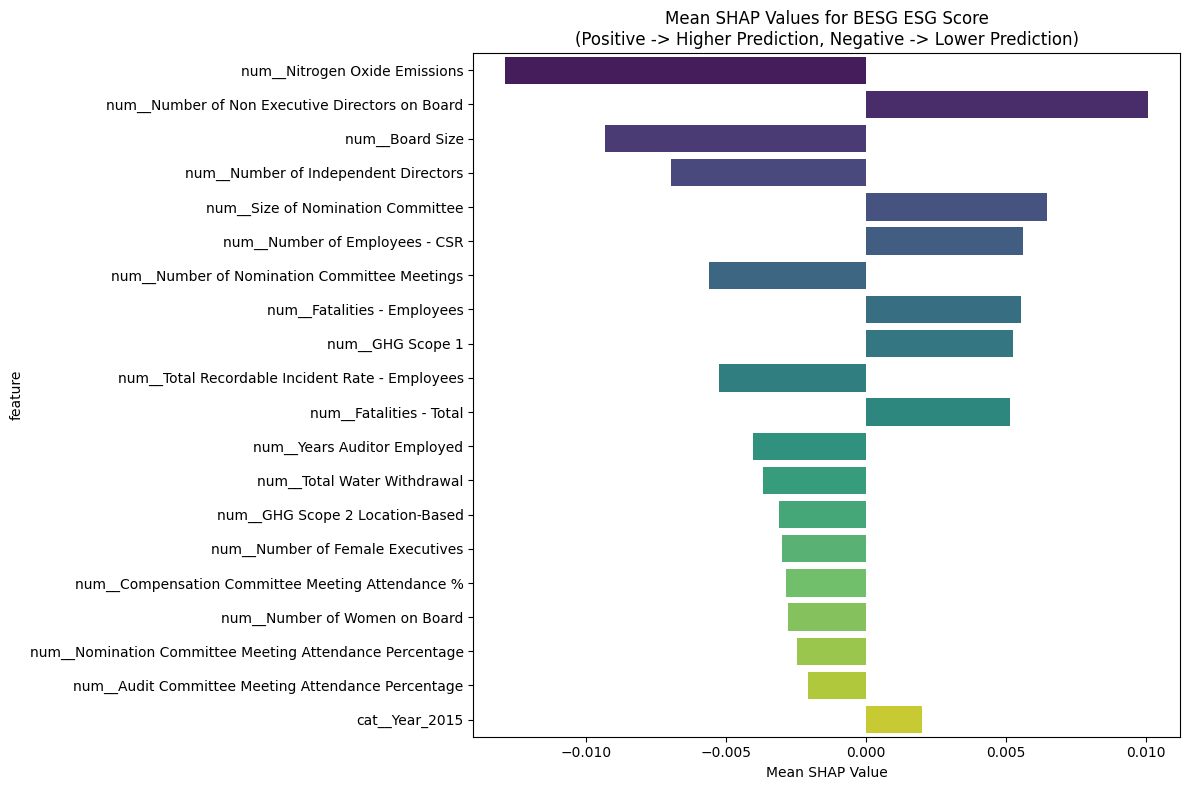

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


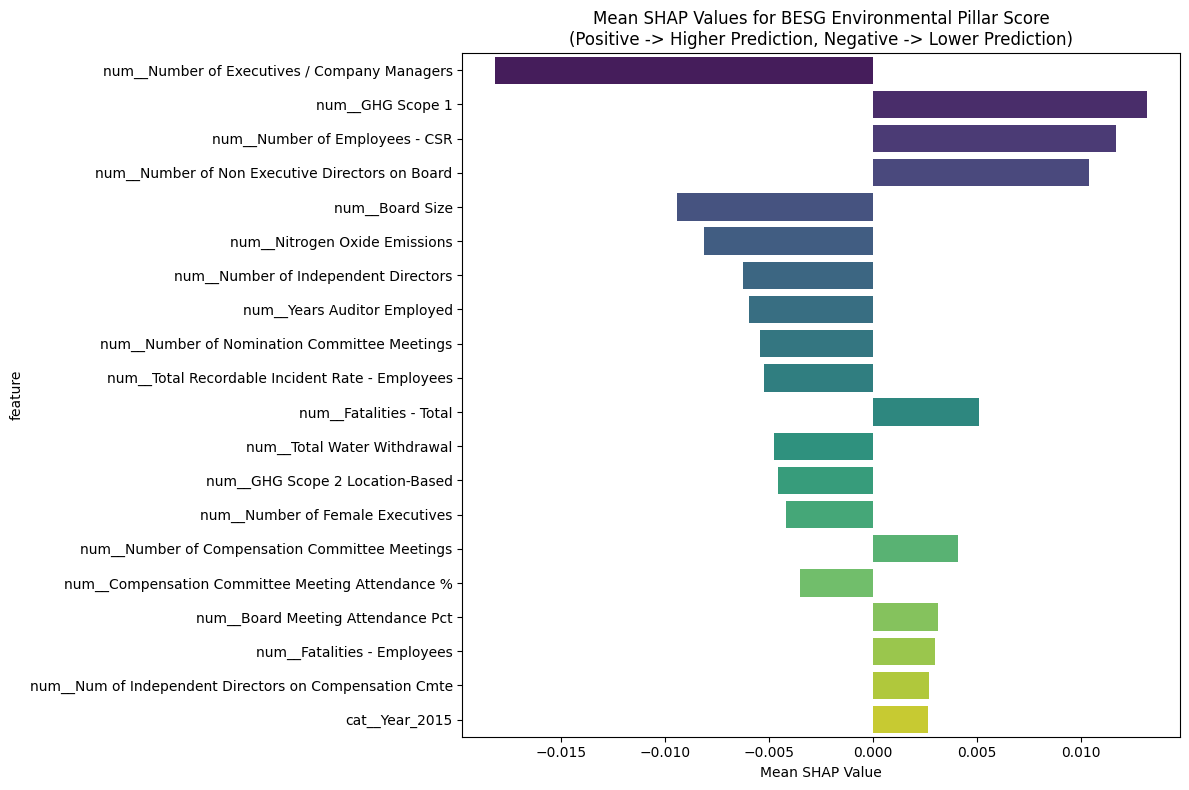

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


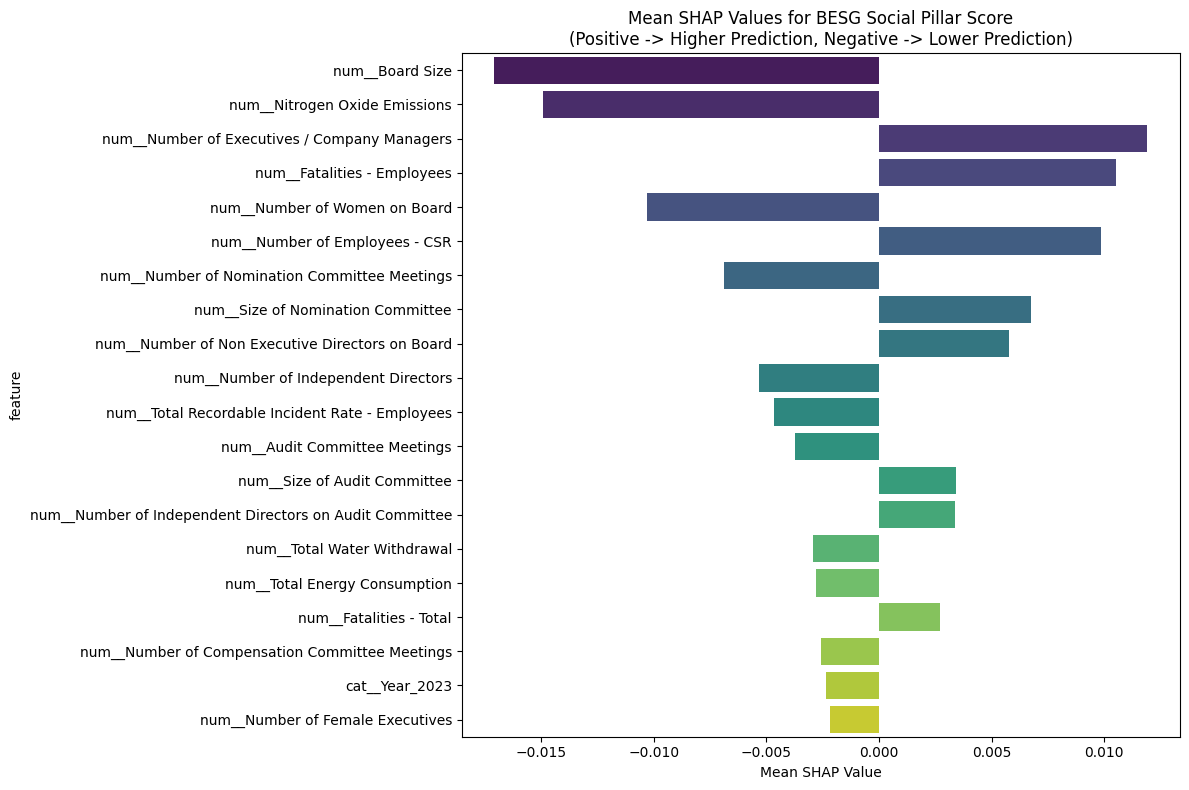

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


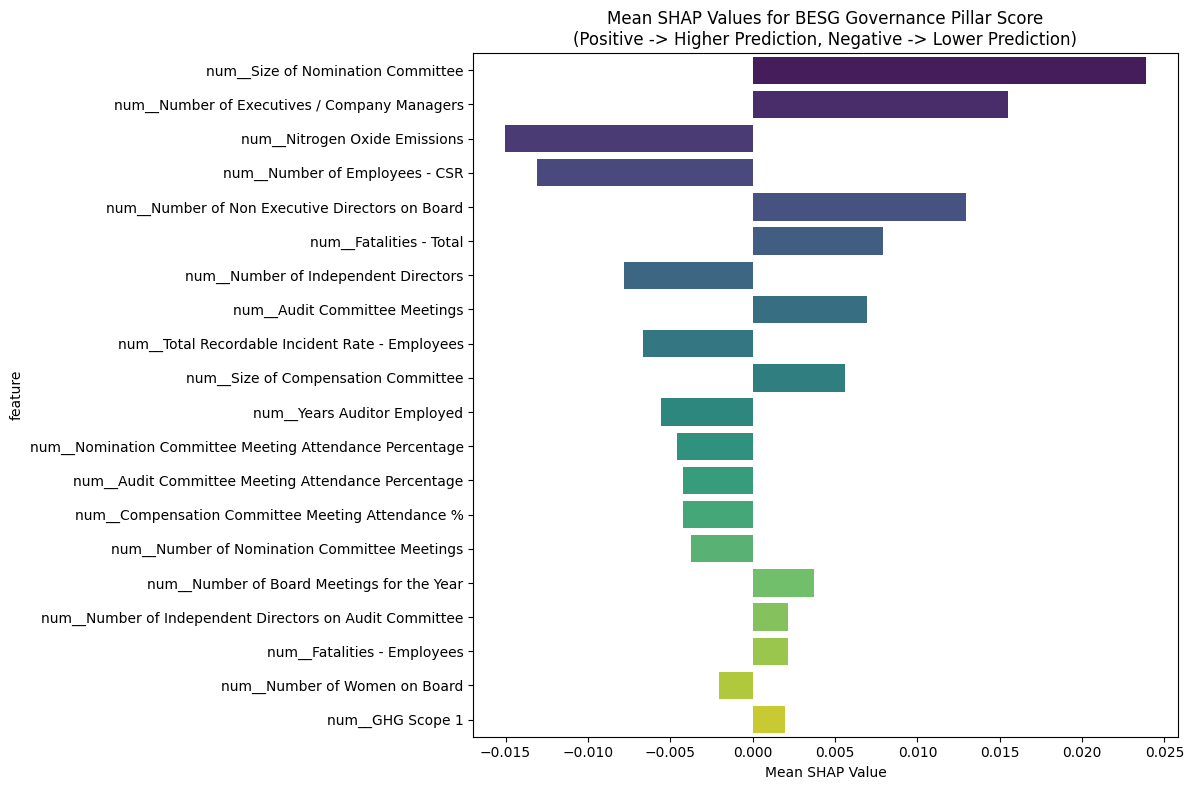

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


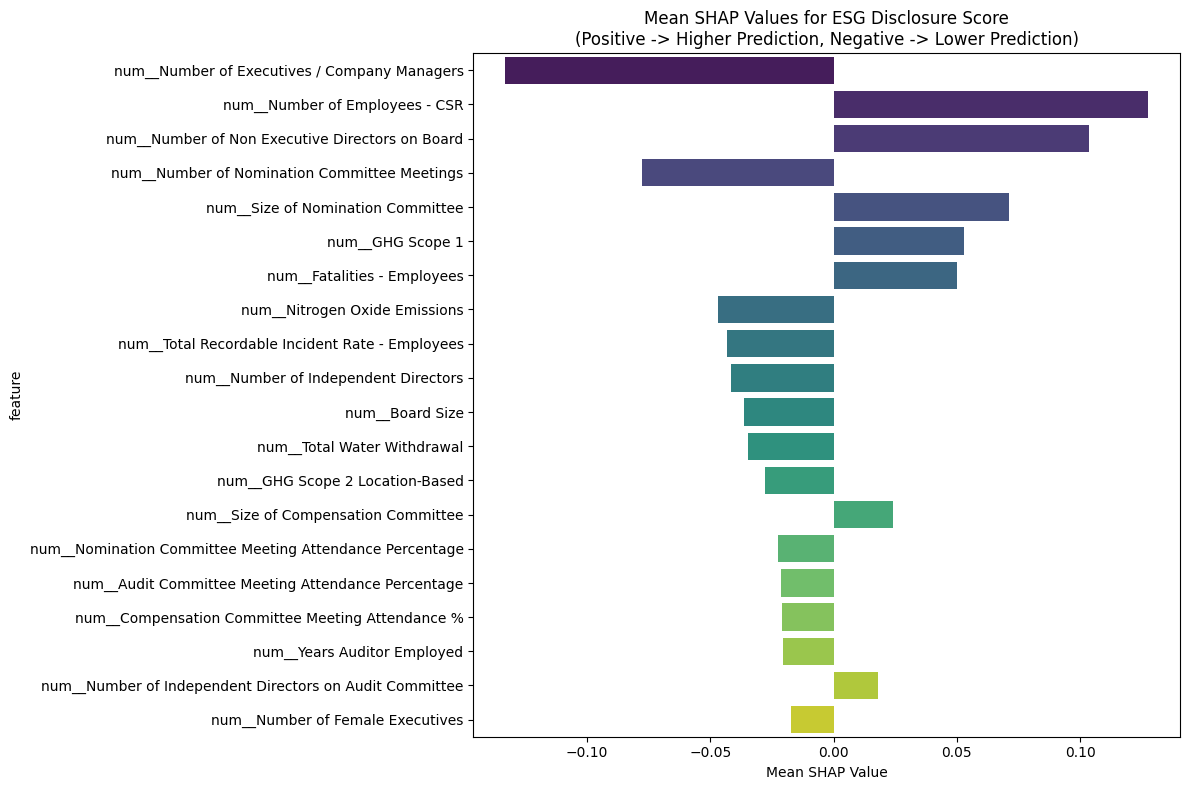

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


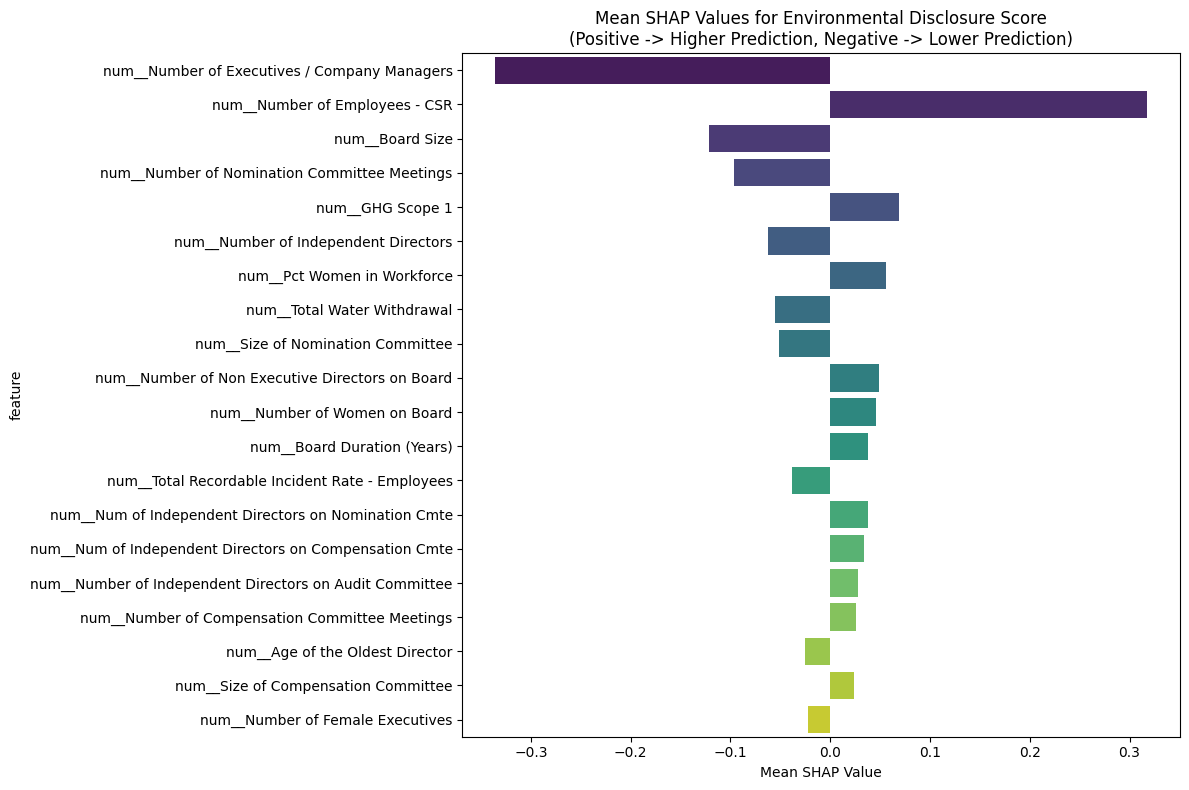

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


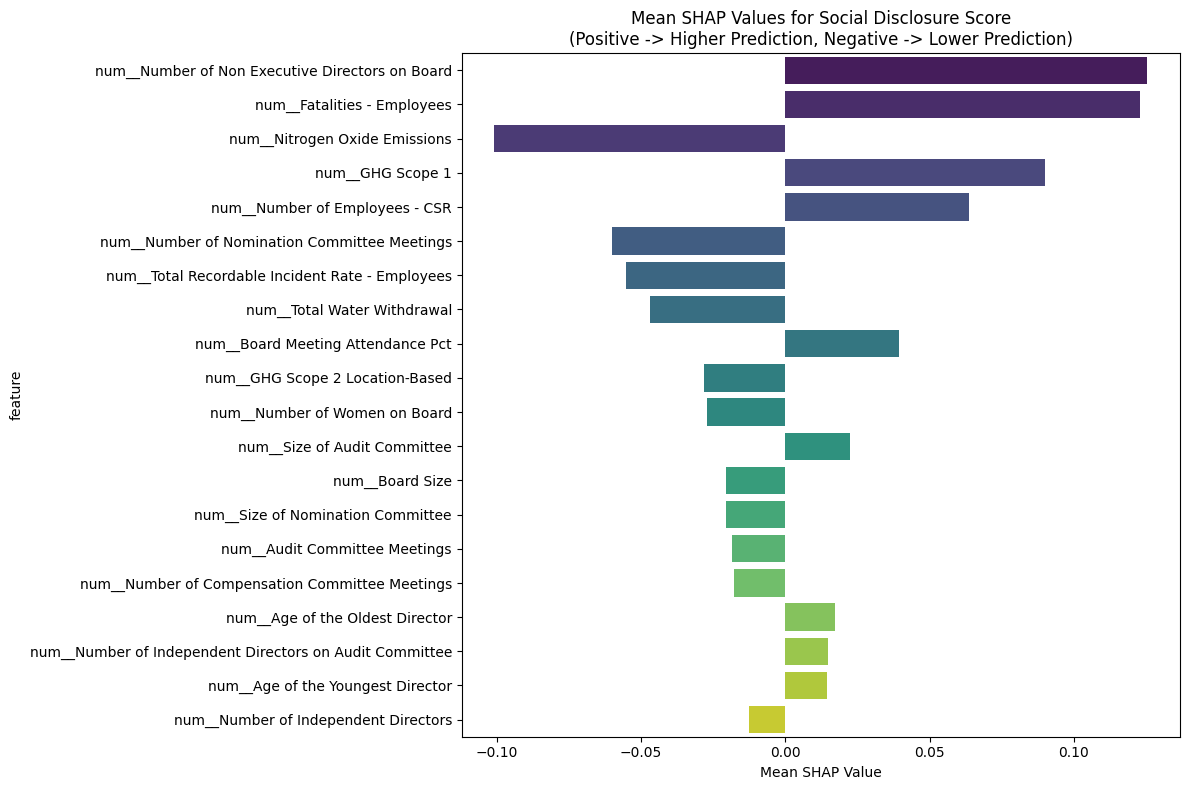

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_21815/610670935.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')


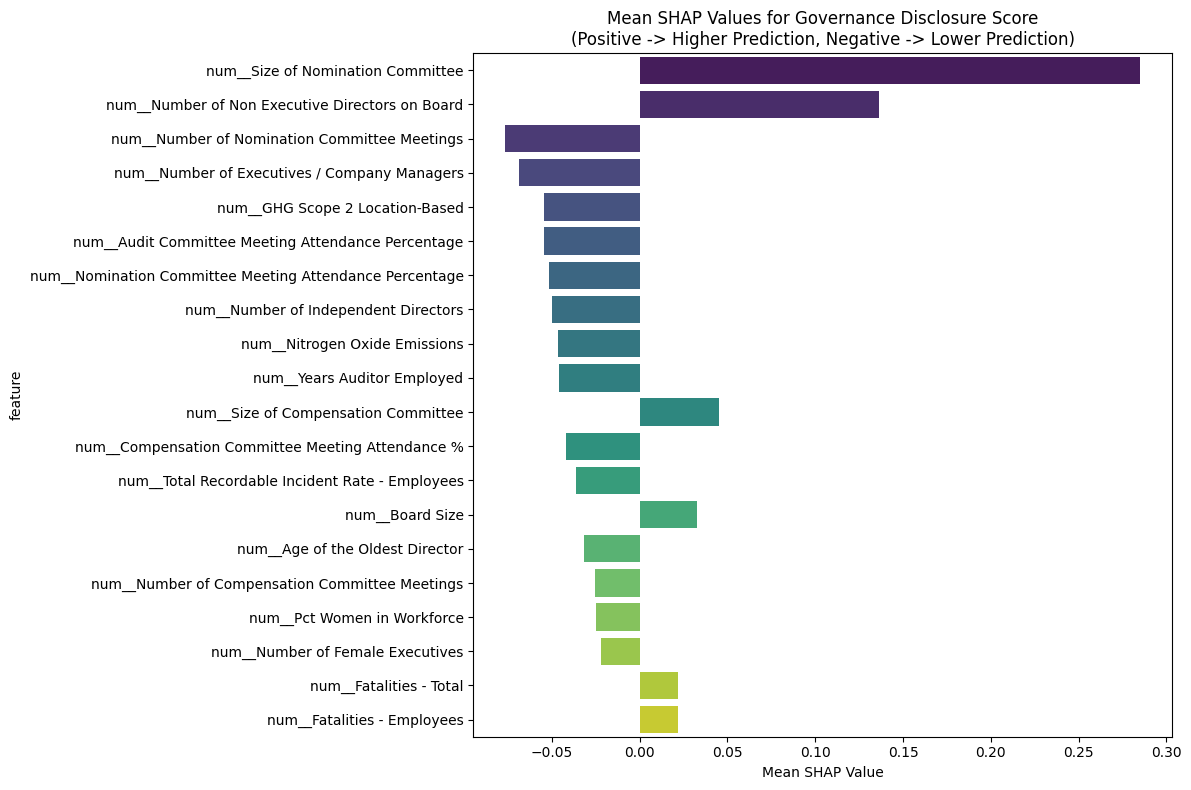

In [36]:
import shap

def analyze_shap_values(rf_model, X, y):
    # Transform X with the preprocessor
    X_preprocessed = rf_model.named_steps['preprocessor'].transform(X)

    # If X_preprocessed is a sparse matrix, convert it to a dense array
    if hasattr(X_preprocessed, "toarray"):
        X_preprocessed = X_preprocessed.toarray()

    # Convert the data type to float (if possible)
    X_preprocessed = X_preprocessed.astype(np.float64)

    # Create the TreeExplainer using your trained RandomForestRegressor
    explainer = shap.TreeExplainer(rf_model.named_steps['regressor'])

    # Compute SHAP values on the preprocessed data
    shap_values = explainer.shap_values(X_preprocessed)

    # Get feature names
    try:
        feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Fallback method if get_feature_names_out() doesn't exist
        feature_names = rf_model.named_steps['preprocessor'].get_feature_names()

    # Prepare output column names
    output_names = y.columns.tolist()

    # For multi-output models, create separate DataFrames for each output
    shap_dfs = []

    # Iterate through each output dimension
    for output_idx in range(shap_values.shape[2]):
        # Take the mean of the SHAP values across all samples for this output
        mean_shap_values = np.mean(shap_values[:, :, output_idx], axis=0)

        # Select top 20 features by absolute SHAP value
        top_feature_indices = np.argsort(np.abs(mean_shap_values))[-20:]

        # Create a DataFrame for this output with only top features
        shap_df = pd.DataFrame({
            'feature': [feature_names[i] for i in top_feature_indices],
            'mean_shap': mean_shap_values[top_feature_indices]
        })

        # Sort by the absolute average SHAP value (descending)
        shap_df = shap_df.reindex(shap_df['mean_shap'].abs().sort_values(ascending=False).index)

        # Plot the bar chart for this output using Seaborn
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='mean_shap', y='feature', data=shap_df, palette='viridis', orient='h')
        plt.xlabel('Mean SHAP Value')
        plt.title(f'Mean SHAP Values for {output_names[output_idx]}\n(Positive -> Higher Prediction, Negative -> Lower Prediction)')
        plt.tight_layout()
        plt.show()

        # Add output name to the DataFrame
        shap_df['output'] = output_names[output_idx]
        shap_dfs.append(shap_df)

    # Combine all output DataFrames
    combined_shap_df = pd.concat(shap_dfs, ignore_index=True)

    return combined_shap_df

shap_dataframe = analyze_shap_values(rf_model, X, y)

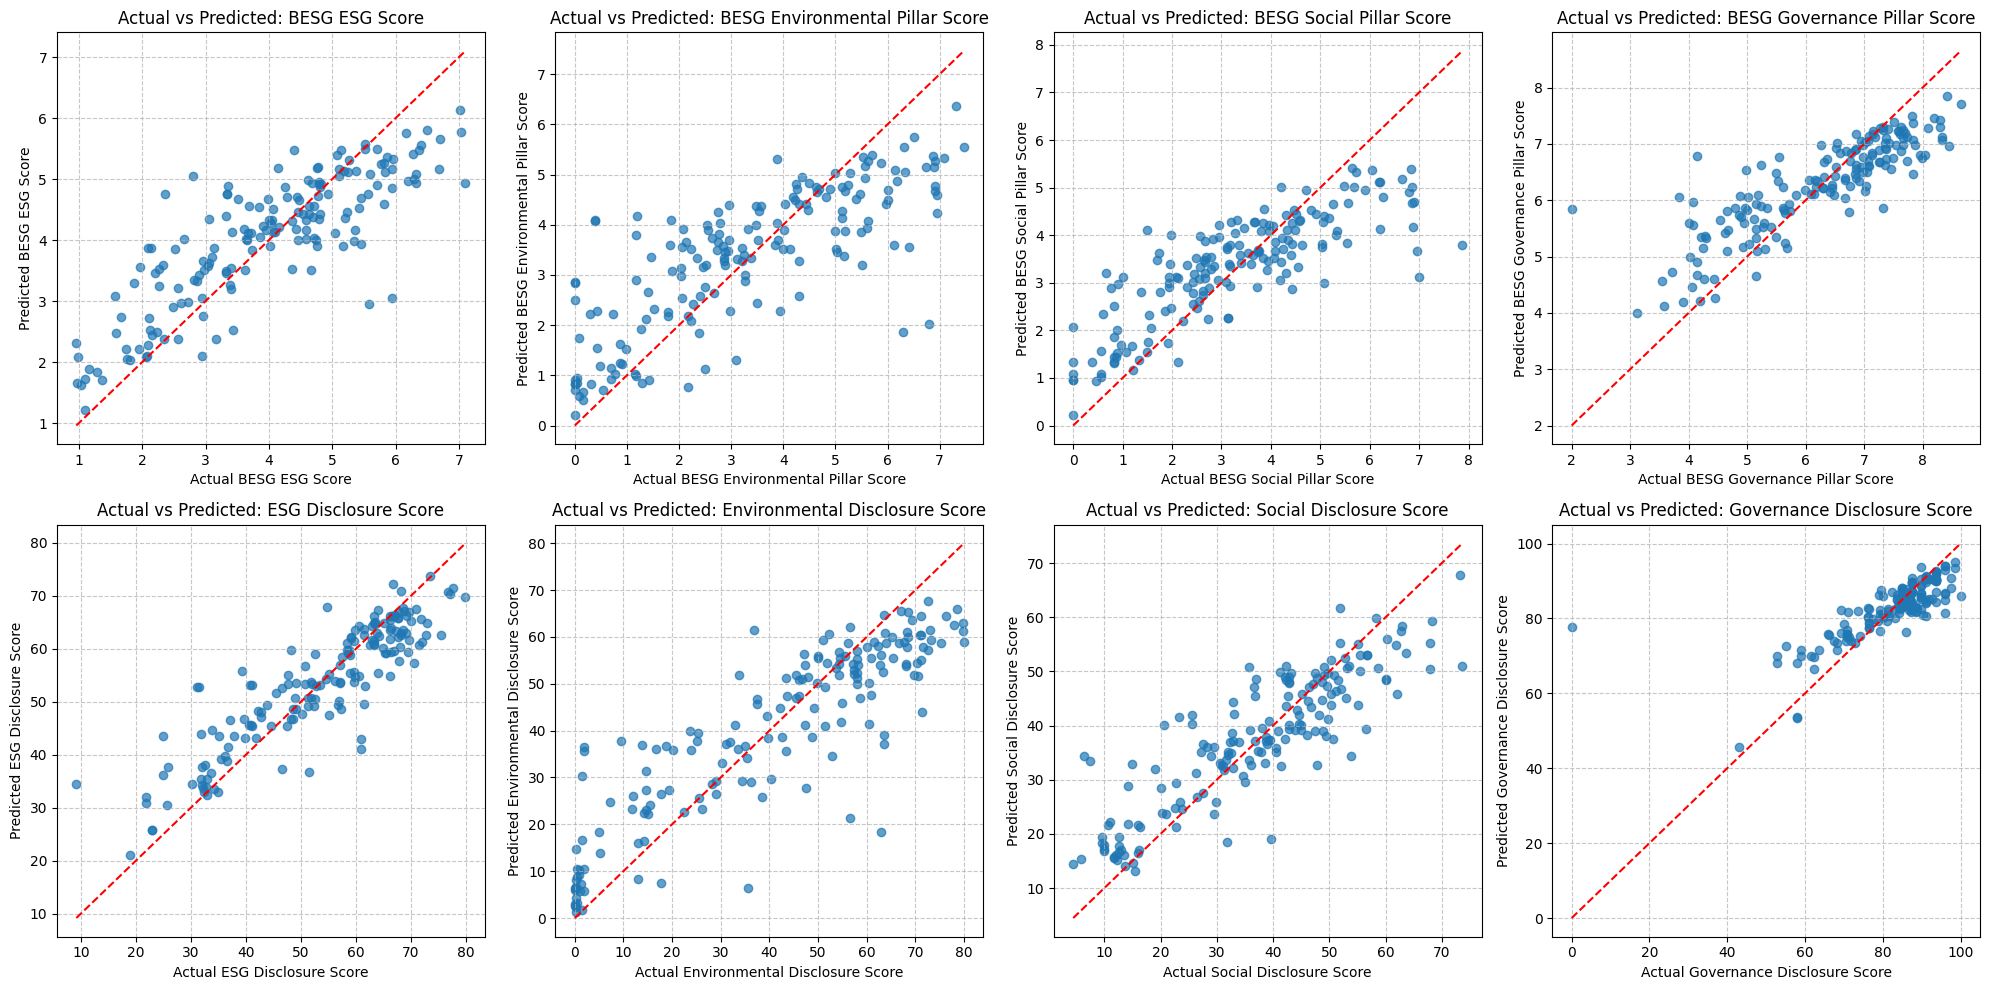

In [26]:
def plot_actual_vs_predicted(y_test, rf_predictions):
    # Determine the number of outputs
    n_outputs = y_test.shape[1]

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()  # Flatten the 2D array of axes

    # Plot for each output
    for i in range(n_outputs):
        # Scatter plot of actual vs predicted for this specific output
        axes[i].scatter(y_test.iloc[:, i], rf_predictions[:, i], alpha=0.7)

        # Add perfect prediction line
        min_val = min(y_test.iloc[:, i].min(), rf_predictions[:, i].min())
        max_val = max(y_test.iloc[:, i].max(), rf_predictions[:, i].max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')

        # Set labels and title
        axes[i].set_xlabel(f'Actual {y_test.columns[i]}')
        axes[i].set_ylabel(f'Predicted {y_test.columns[i]}')
        axes[i].set_title(f'Actual vs Predicted: {y_test.columns[i]}')
        axes[i].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Usage example:
plot_actual_vs_predicted(y_test, rf_predictions)